data augmentation 활용
맨 뒤 30개의 레이어만 재학습

# 실행 1

**완전연결계층 dropout 비율이 모두 0.5로 고정되어 있을 때**

accuracy : 0.5797

loss : 0.9848



---


Total params: 2,342,180 (8.93 MB)

Trainable params: 1,456,676 (5.56 MB)

Non-trainable params: 885,504 (3.38 MB)

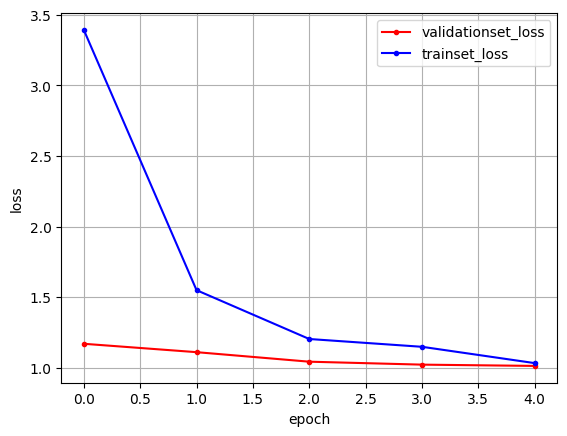

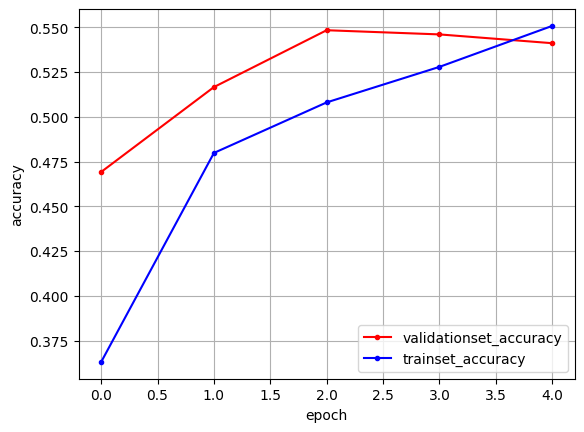

# 실행 2

**첫번째 완전연결계층에만 비율이 모두 0.5인 dropout layer가 연결되어 있을 때**

accuracy : 0.5326

loss : 1.1664



---

Total params: 2,342,180 (8.93 MB)

Trainable params: 1,456,676 (5.56 MB)

Non-trainable params: 885,504 (3.38 MB)

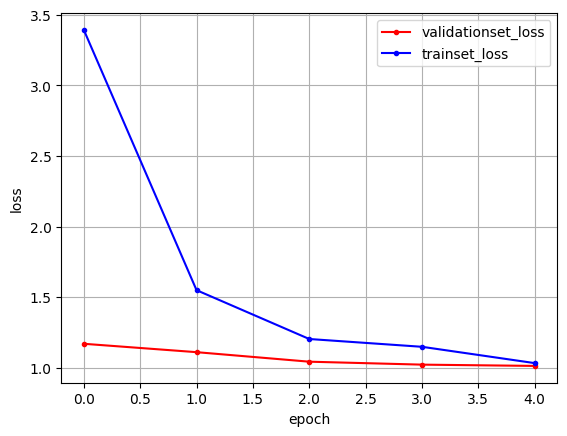

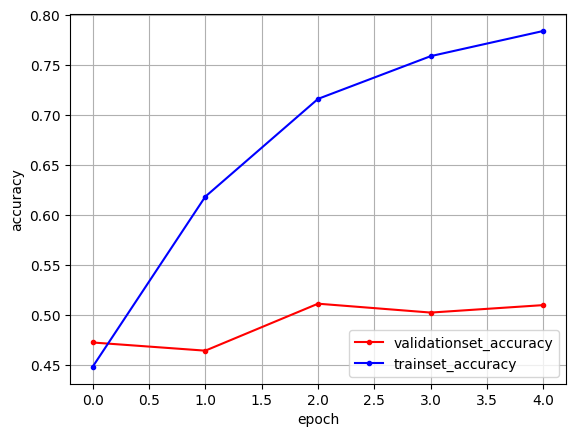

# 실행 3

**구조 수정 **

```
# 코드로 형식 지정됨
model = Sequential([
    base_model,
    Dense(32, activation = 'relu'),
    Dropout(0.5),
    Dense(class_count, activation = 'softmax')
])
```

accuracy : 0.5799

loss : 1.1740



---

Total params: 2,299,108 (8.77 MB)

Trainable params: 1,413,604 (5.39 MB)

Non-trainable params: 885,504 (3.38 MB)

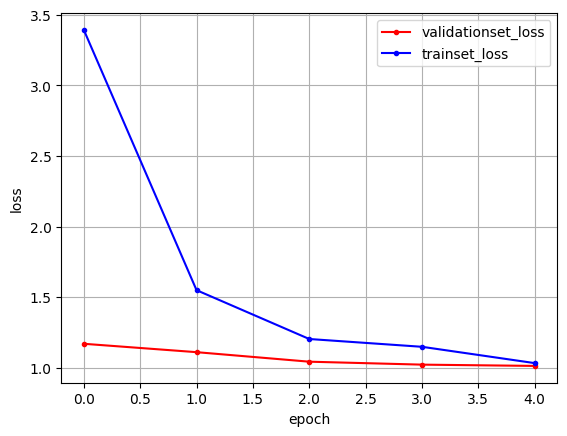

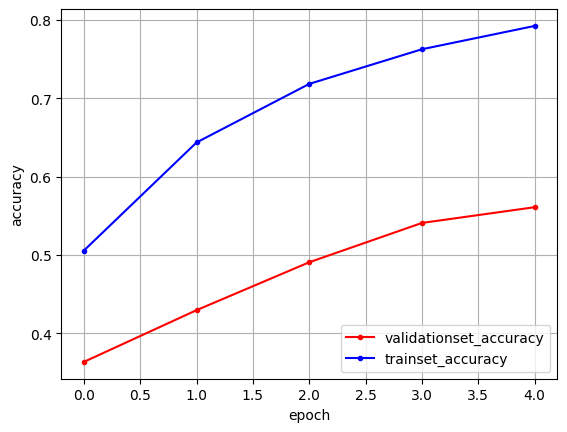



# 실행 4

**구조 수정 **

```
# 코드로 형식 지정됨
model = Sequential([
    base_model,
    Dense(class_count, activation = 'softmax')
])

```

accuracy : 0.5971

loss : 1.1030



---

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 1,377,604 (5.26 MB)

 Non-trainable params: 885,504 (3.38 MB)

 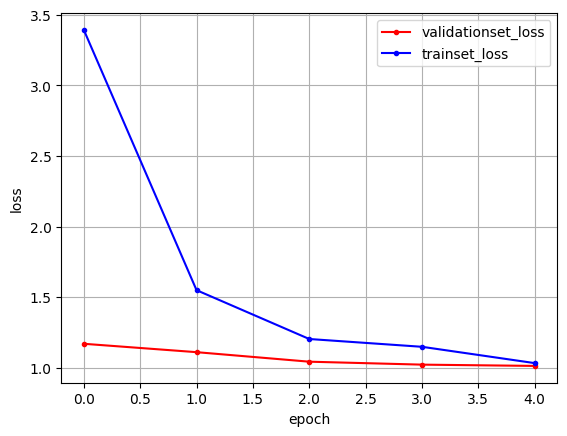

 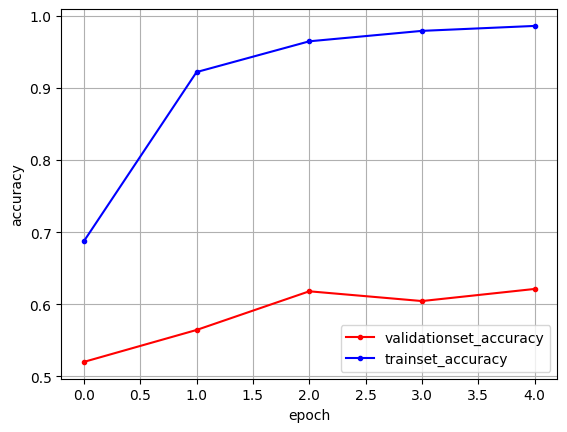



# 실행 5

**구조 수정 **

```
# 코드로 형식 지정됨
class_count = len(list(train_gen.class_indices.keys()))
base_model = MobileNetV2(include_top = False, weights = 'imagenet',
                         input_shape = img_shape, pooling = 'max')
base_model.trainable = False
for i in range(30):
  base_model.layers[-i].trainable = True

np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)


model = Sequential([
    base_model,
    BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001),
    Dense(56, kernel_regularizer = regularizers.l2(0.016),
          #activity_regularizer = regularizers.l1(0.006),
          activation = 'relu'),
    Dropout(rate = 0.45, seed = seed),
    Dense(class_count, activation = 'softmax')
])

model.build(input_shape = (None, *img_shape))
model.summary()

```

accuracy : 0.6928

loss : 2.7332



---
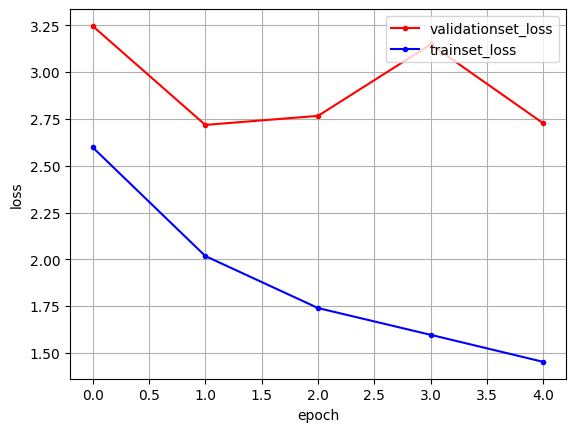

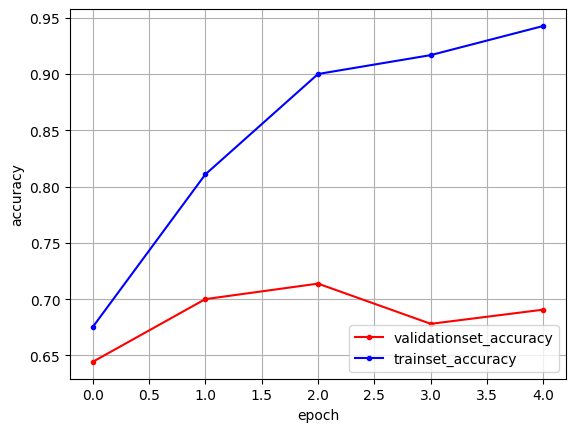

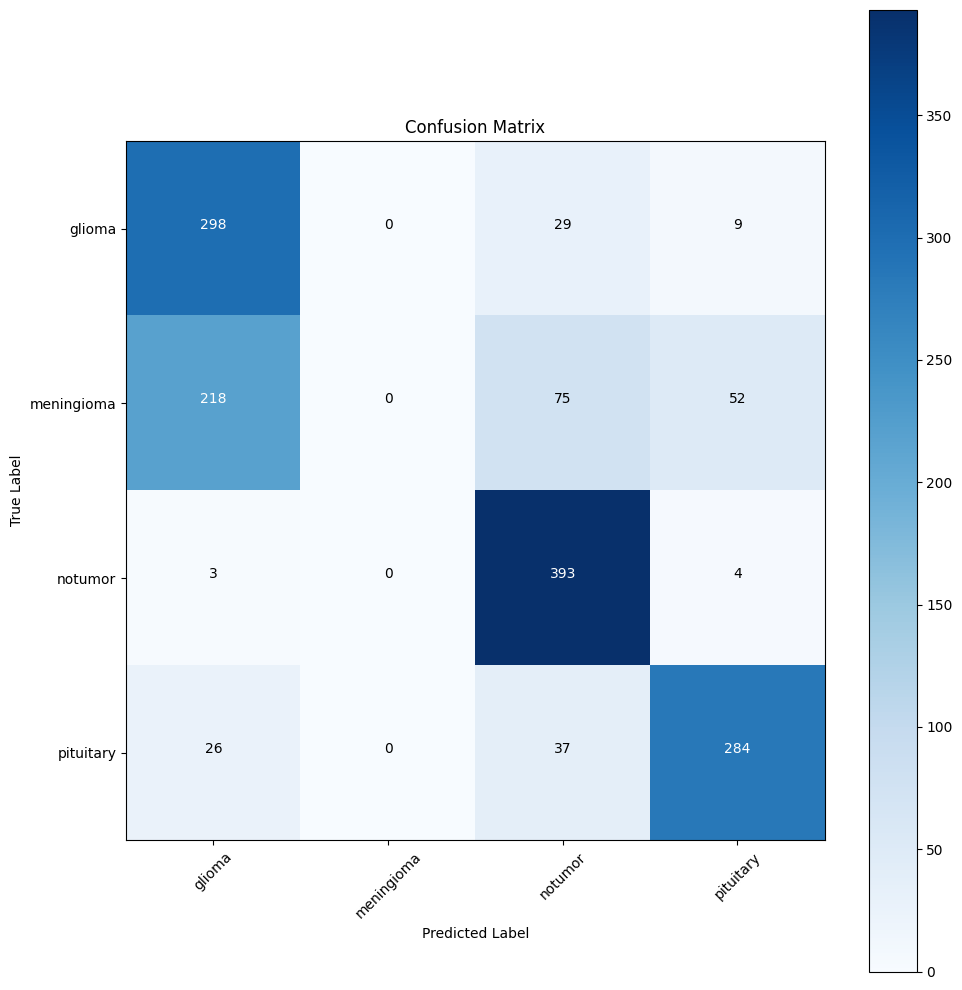


Classification Report:
              precision    recall  f1-score   support

      glioma       0.55      0.89      0.68       336
  meningioma       0.00      0.00      0.00       345
     notumor       0.74      0.98      0.84       400
   pituitary       0.81      0.82      0.82       347

    accuracy                           0.68      1428
   macro avg       0.52      0.67      0.58      1428
weighted avg       0.53      0.68      0.59      1428


# 데이터 준비

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
import random
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [ ]:
seed = 126
IMAGE_SIZE = (224, 224)

In [ ]:
batch_size = 128

Number of images in training:  5712
Number of images in testing:  1311


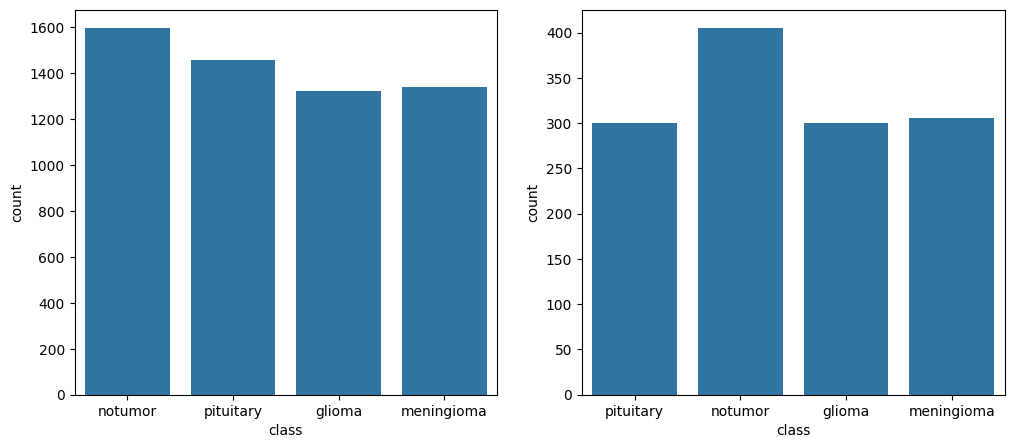

In [ ]:
root_path = '/content/drive/MyDrive/2024urop/dataset'
labels = []
trainFolder = root_path+'/Training/'
testFolder = root_path+'/Testing/'

quantity_tr = {}
quantity_te = {}
for folder in os.listdir(trainFolder):
    quantity_tr[folder] = len(os.listdir(trainFolder+folder))
    labels.append(folder)

for folder in os.listdir(testFolder):
    quantity_te[folder] = len(os.listdir(testFolder+folder))


quantity_train = pd.DataFrame(list(quantity_tr.items()),
                              index=range(0,len(quantity_tr)), columns=['class','count'])

quantity_test = pd.DataFrame(list(quantity_te.items()),
                              index=range(0,len(quantity_te)), columns=['class','count'])

figure, ax = plt.subplots(1,2,figsize=(12,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])

print("Number of images in training: ", sum(quantity_tr.values()))
print("Number of images in testing: ", sum(quantity_te.values()))

plt.show()

In [ ]:
labels

['notumor', 'pituitary', 'glioma', 'meningioma']

In [ ]:
# reading the dataset
X_train = []
y_train = []

X_test = []
y_test = []

for i in labels:
    folderPath = os.path.join(root_path,'Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j), 1)
        img = cv2.resize(img,(IMAGE_SIZE[0], IMAGE_SIZE[1]))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join(root_path,'Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j), 1)
        img = cv2.resize(img,(IMAGE_SIZE[0], IMAGE_SIZE[1]))
        X_test.append(img)
        y_test.append(i)

100%|██████████| 306/306 [00:04<00:00, 75.18it/s] 


In [ ]:
# python list to numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
# rescaling
X_train=X_train/255.0
X_test=X_test/255.0

In [ ]:
print(np.min(X_train), np.max(X_train))

0.0 1.0


In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5712, 224, 224, 3) (5712,)
(1311, 224, 224, 3) (1311,)


In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5712, 224, 224, 3) (5712, 4)
(1311, 224, 224, 3) (1311, 4)


In [ ]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

train_datagen = ImageDataGenerator(
        rotation_range=20,         # 이미지를 무작위로 0도에서 20도까지 회전
        width_shift_range=0.2,     # 이미지를 좌우로 무작위 이동 (전체 가로 길이의 20%까지)
        height_shift_range=0.2,    # 이미지를 위아래로 무작위 이동 (전체 세로 길이의 20%까지)
        shear_range=0.15,          # 이미지를 무작위로 전단 변환
        zoom_range=0.2,            # 이미지를 무작위로 확대/축소 (0.8배에서 1.2배 사이)
        horizontal_flip=True,      # 이미지를 수평으로 무작위 뒤집기
        fill_mode='nearest',
        validation_split = 0.2
)
test_datagen = ImageDataGenerator()


train_ds = train_datagen.flow(
  X_train, y_train,
  subset="training",
  shuffle=True,
  batch_size=batch_size)

In [ ]:
val_ds = train_datagen.flow(
  X_train, y_train,
  subset="validation",
  shuffle=True,
  batch_size=batch_size)

In [ ]:
test_ds = test_datagen.flow(
  X_test, y_test,
  shuffle=False,
  batch_size=batch_size)

In [ ]:
j = 0
class_mapping = {}
for i in labels:
    class_mapping[j] = i
    j+=1

class_mapping

{0: 'notumor', 1: 'pituitary', 2: 'glioma', 3: 'meningioma'}

In [ ]:
def show_few_images(number_of_examples=2, predict_using_model=None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(testFolder)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(testFolder)):
        image_ids = os.listdir(os.path.join(testFolder,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:

            display = cv2.imread(os.path.join(testFolder,folder,image_ids[j]),1)
            display = cv2.resize(display, (IMAGE_SIZE[0], IMAGE_SIZE[1]))/255.0
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True: '+folder
            if(predict_using_model):
                result = predict_using_model.predict(np.array([display]))
                #print(result)
                acc = str(round(np.max(result)*100, 3))
                predicted_classname = class_mapping[np.argmax(result)]
                title = title+'\nPrediction : '+predicted_classname+" - "+acc+"%"
            ax1[axs].set_title(title)
            axs=axs+1

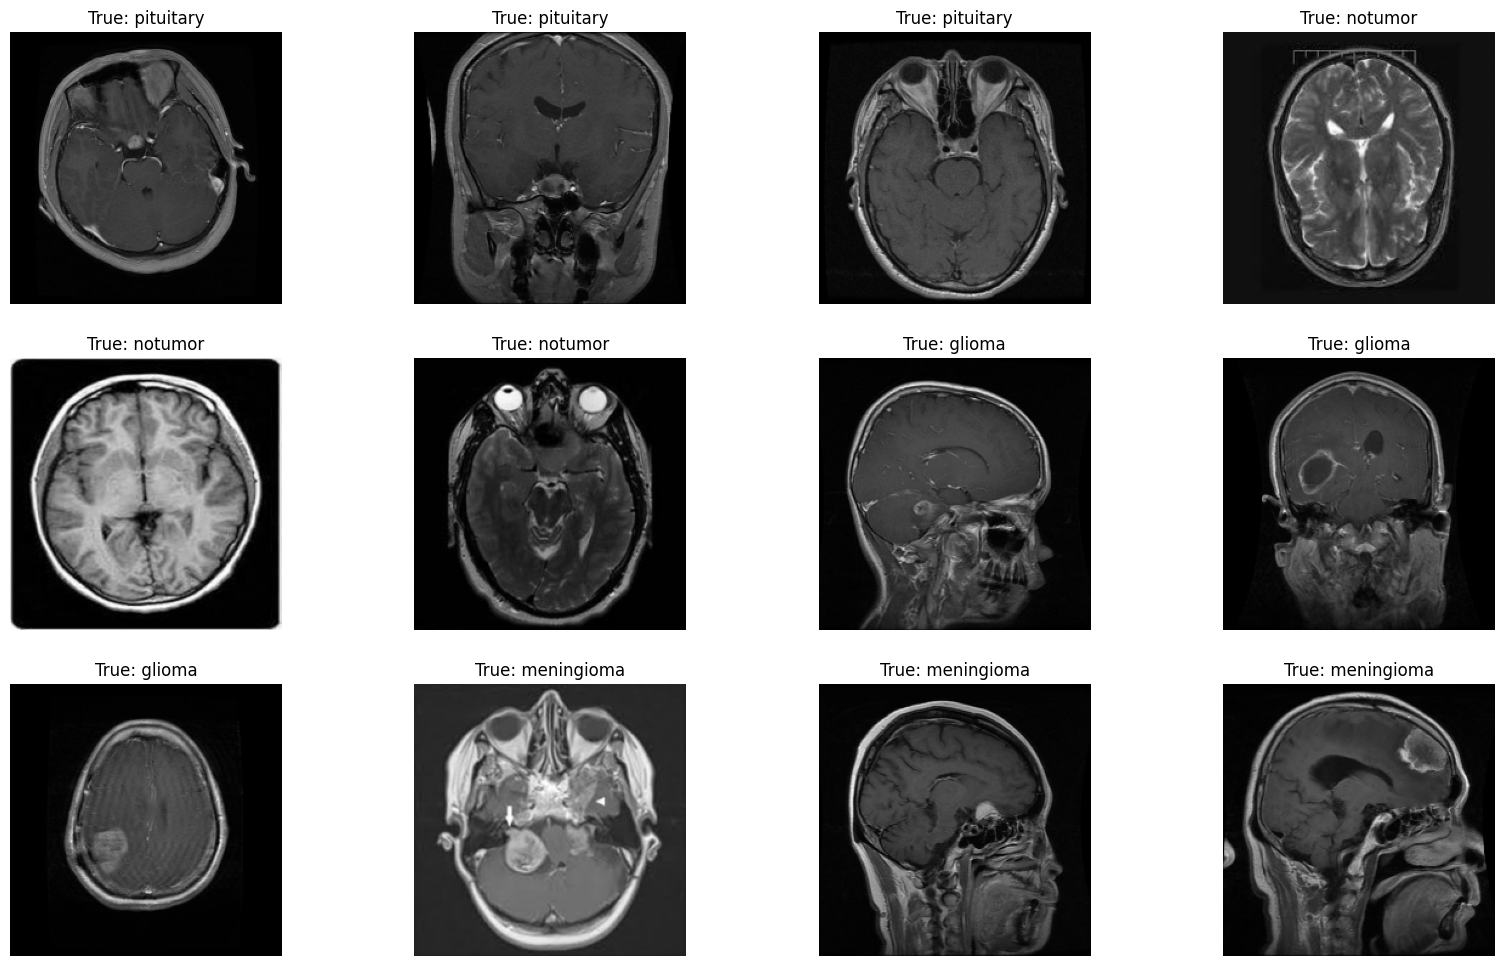

In [ ]:
show_few_images(3)

# 모델 구조

In [ ]:
class_count = 4
channels = 3
base_model = MobileNetV2(include_top = False, weights = 'imagenet',
                         input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], channels), pooling = 'max')
base_model.trainable = False
for i in range(30):
  base_model.layers[-i].trainable = True

np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)


model = Sequential([
    base_model,
    BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001),
    Dense(128, kernel_regularizer = regularizers.l2(0.016),
          activity_regularizer = regularizers.l1(0.006),
          activation = 'relu'),
    Dropout(rate = 0.45, seed = 123),
    Dense(class_count, activation = 'softmax')
])

model.build(input_shape = (None, *(IMAGE_SIZE[0], IMAGE_SIZE[1], channels)))
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                           

# 모델 실행

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = Adamax(learning_rate = 0.001), metrics = ['accuracy'])

In [ ]:
modelpath = '/content/drive/MyDrive/2024urop/model/plain/plain3-bestmodel.keras'
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)
checkpointer = ModelCheckpoint(filepath = modelpath, monitor = 'val_loss', verbose = 1, save_best_only = True)
history = model.fit(train_ds, validation_data = val_ds, epochs = 100, callbacks = [early_stopping, checkpointer])

Epoch 1/100
36/36 [==============================] - ETA: 0s - loss: 4.6526 - accuracy: 0.7068
Epoch 1: val_loss improved from inf to 5.32895, saving model to /content/drive/MyDrive/2024urop/model/plain/plain3-bestmodel.keras
36/36 [==============================] - 80s 2s/step - loss: 4.6526 - accuracy: 0.7068 - val_loss: 5.3290 - val_accuracy: 0.4799
Epoch 2/100
36/36 [==============================] - ETA: 0s - loss: 3.8059 - accuracy: 0.8105
Epoch 2: val_loss improved from 5.32895 to 4.46736, saving model to /content/drive/MyDrive/2024urop/model/plain/plain3-bestmodel.keras
36/36 [==============================] - 74s 2s/step - loss: 3.8059 - accuracy: 0.8105 - val_loss: 4.4674 - val_accuracy: 0.5385
Epoch 3/100
36/36 [==============================] - ETA: 0s - loss: 3.2700 - accuracy: 0.8328
Epoch 3: val_loss improved from 4.46736 to 3.50905, saving model to /content/drive/MyDrive/2024urop/model/plain/plain3-bestmodel.keras
36/36 [==============================] - 73s 2s/step - l

In [ ]:
print("\n Test Accuracy: %4.f" %(model. evaluate(test_ds) [1]))

11/11 [==============================] - 9s 826ms/step - loss: 0.4962 - accuracy: 0.8726

 Test Accuracy:    1


# 그래프 표현

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

In [ ]:
y_vacc = history.history['val_accuracy']
y_acc = history.history['accuracy']

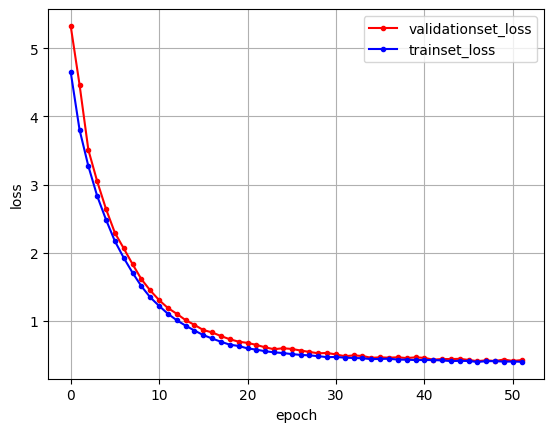

In [ ]:
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker = '.', c = 'red', label = 'validationset_loss')
plt.plot(x_len, y_loss, marker = '.', c = 'blue', label = 'trainset_loss')
plt.legend(loc = 'upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

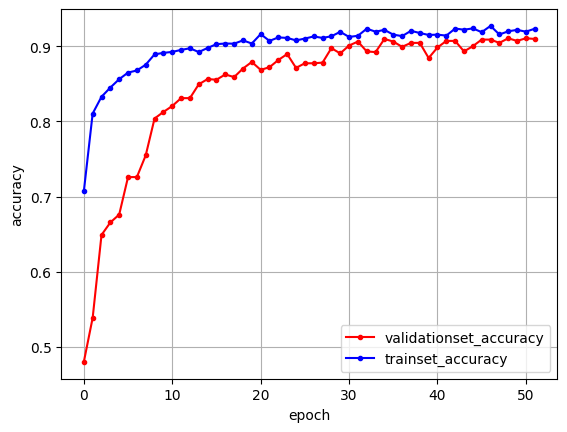

In [ ]:
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vacc, marker = '.', c = 'red', label = 'validationset_accuracy')
plt.plot(x_len, y_acc, marker = '.', c = 'blue', label = 'trainset_accuracy')
plt.legend(loc = 'lower right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

# 혼동 행렬 표현

In [ ]:
train_score = model.evaluate(train_ds ,  verbose = 1)
valid_score = model.evaluate(val_ds ,  verbose = 1)
test_score = model.evaluate(test_ds ,  verbose = 1)

11/11 [==============================] - 10s 838ms/step - loss: 0.4962 - accuracy: 0.8726


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools

In [ ]:
# 모델 예측값 생성
y_pred = np.argmax(model.predict(test_ds), axis=-1)

# 실제 레이블 가져오기 (y_test가 원핫 인코딩된 경우)
y_true = np.argmax(y_test, axis=-1)

# 혼동 행렬 계산 및 출력
cm = confusion_matrix(y_true, y_pred)
print(cm)

11/11 [==============================] - 9s 825ms/step
[[382   8   4  11]
 [  0 298   1   1]
 [  0  15 251  34]
 [ 31  46  16 213]]


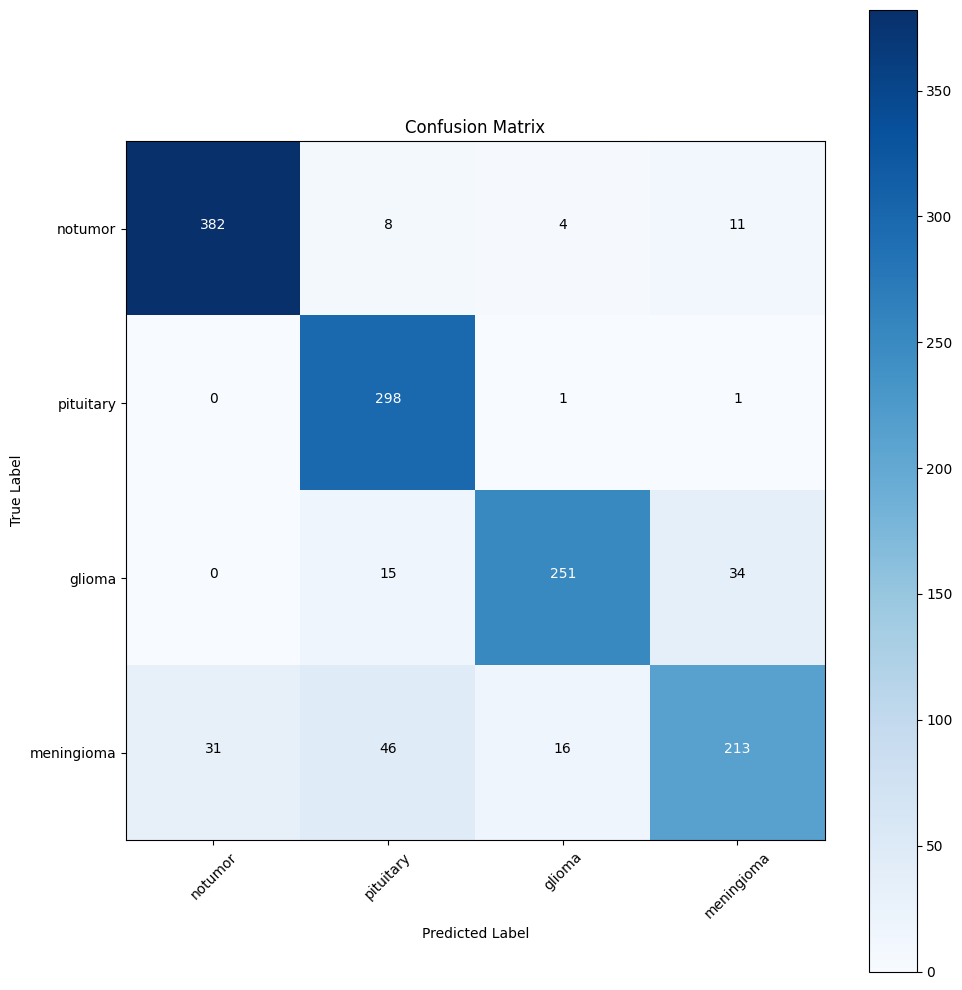

In [ ]:
plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation= 45)
plt.yticks(tick_marks, labels)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [ ]:
print("Classification Report:")
report = classification_report(y_true, y_pred, target_names=labels)
print(report)

Classification Report:
              precision    recall  f1-score   support

     notumor       0.92      0.94      0.93       405
   pituitary       0.81      0.99      0.89       300
      glioma       0.92      0.84      0.88       300
  meningioma       0.82      0.70      0.75       306

    accuracy                           0.87      1311
   macro avg       0.87      0.87      0.86      1311
weighted avg       0.87      0.87      0.87      1311

